<a href="https://colab.research.google.com/github/tmehtiyev2019/EEGViT/blob/master/city_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

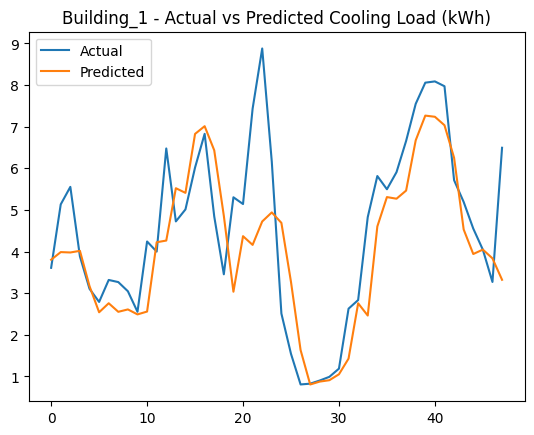

RMSE for Building_1 - Cooling Load (kWh): 1.3476882629846043


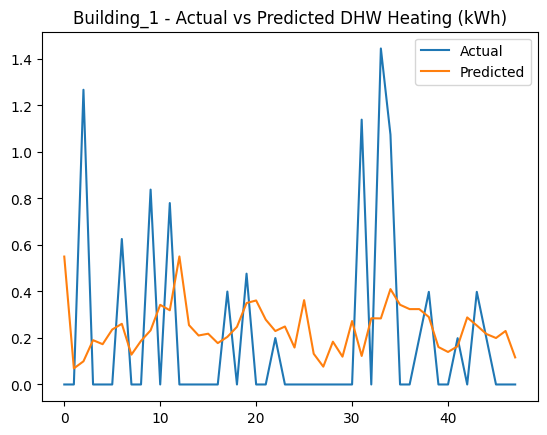

RMSE for Building_1 - DHW Heating (kWh): 0.38911325807755276


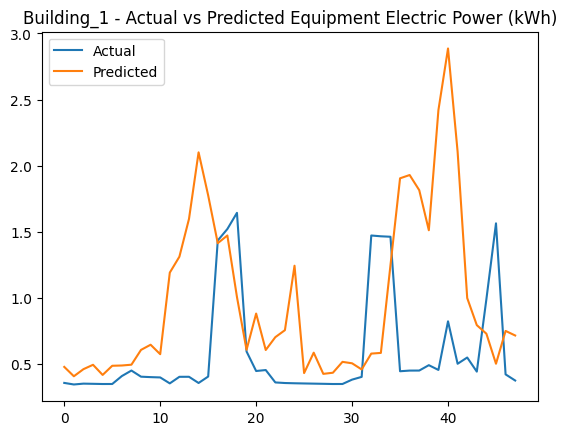

RMSE for Building_1 - Equipment Electric Power (kWh): 0.805864333396411


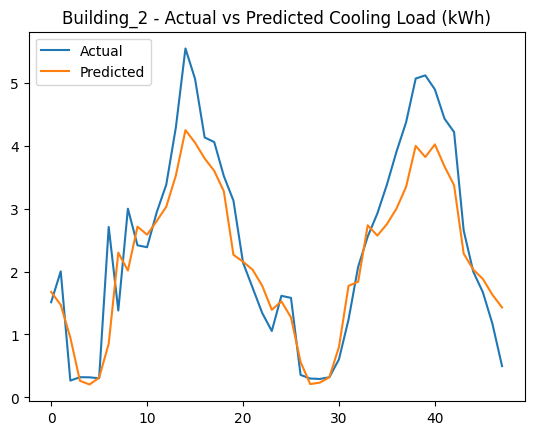

RMSE for Building_2 - Cooling Load (kWh): 0.6484351753127643


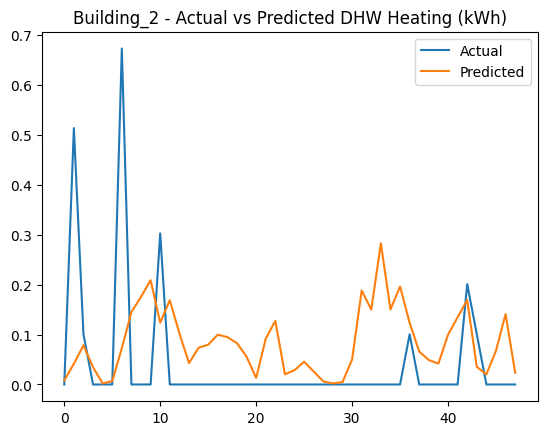

RMSE for Building_2 - DHW Heating (kWh): 0.15084702057327085


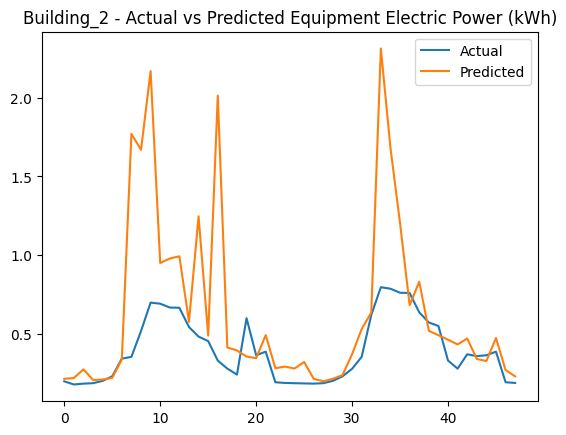

RMSE for Building_2 - Equipment Electric Power (kWh): 0.5162002748019464


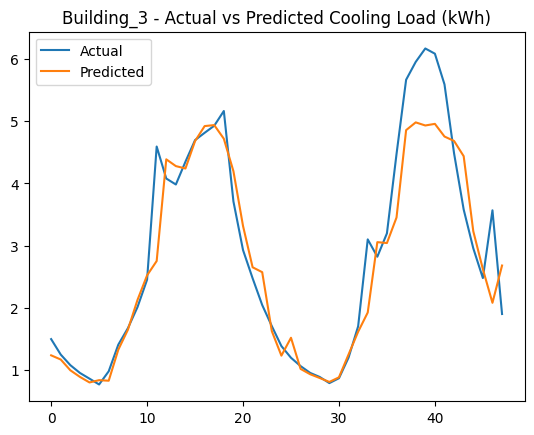

RMSE for Building_3 - Cooling Load (kWh): 0.5783906536522504


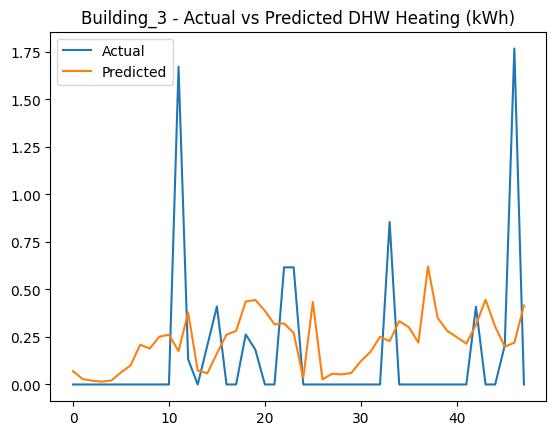

RMSE for Building_3 - DHW Heating (kWh): 0.40441937255397176


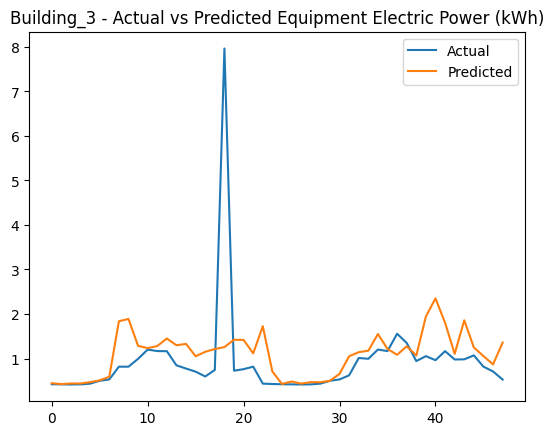

RMSE for Building_3 - Equipment Electric Power (kWh): 1.0859326005595156




{'Building_1': {'Cooling Load (kWh)': 1.3476882629846043,
  'DHW Heating (kWh)': 0.38911325807755276,
  'Equipment Electric Power (kWh)': 0.805864333396411},
 'Building_2': {'Cooling Load (kWh)': 0.6484351753127643,
  'DHW Heating (kWh)': 0.15084702057327085,
  'Equipment Electric Power (kWh)': 0.5162002748019464},
 'Building_3': {'Cooling Load (kWh)': 0.5783906536522504,
  'DHW Heating (kWh)': 0.40441937255397176,
  'Equipment Electric Power (kWh)': 1.0859326005595156}}

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler

# Function to add cyclical encoding for the 'Hour' feature
def add_cyclical_encoding(df, column):
    max_val = df[column].max()
    df[column + '_sin'] = np.sin(2 * np.pi * df[column] / max_val)
    df[column + '_cos'] = np.cos(2 * np.pi * df[column] / max_val)
    return df

# Function to create lagged features
def create_lagged_features(df, columns, n_lags):
    lagged_data = {}
    for column in columns:
        for lag in range(1, n_lags + 1):
            lagged_data[f'{column}_lag_{lag}'] = df[column].shift(lag)
    lagged_df = pd.DataFrame(lagged_data, index=df.index)
    return pd.concat([df, lagged_df], axis=1)

# Function to process the dataset, train the model, predict and calculate RMSE
def process_building_data(building_df):
    building_df['Timestamp'] = pd.date_range(start='6/1/2023', periods=len(building_df), freq='H')
    building_df.set_index('Timestamp', inplace=True)

    # Define the features and target columns
    features = [col for col in building_df.columns if col not in ['Cooling Load (kWh)', 'DHW Heating (kWh)', 'Equipment Electric Power (kWh)']]
    target = ['Cooling Load (kWh)', 'DHW Heating (kWh)', 'Equipment Electric Power (kWh)']

    # Add cyclical encoding
    building_df = add_cyclical_encoding(building_df, 'Hour')

    # Create 48 lagged features for each target variable
    building_df = create_lagged_features(building_df, target, 48)
    building_df = building_df.copy()  # This consolidates the DataFrame

    # Drop rows with NaN values created by lagging
    building_df.dropna(inplace=True)

    # Split the data
    X = building_df[[col for col in building_df.columns if 'lag' in col]]  # Keep only lagged features
    y = building_df[target]#.iloc[48:]  # Align with the lagged features

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    y_test_subset = y_test.tail(48)  # We will predict the last 48 time steps

    # Normalize features with MinMaxScaler
    scaler = MinMaxScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)


    # Train the model
    model = RandomForestRegressor(n_estimators=100, random_state=42)  # Set random state for reproducibility
    model.fit(X_train_scaled, y_train)

    # Predict using only the lagged features from the test set
    predictions = model.predict(X_test_scaled.tail(48))
    predictions_df = pd.DataFrame(predictions, index=y_test_subset.index,
                                  columns=target)

    # Calculate RMSE
    rmse_values = {}
    for column in y_test_subset.columns:
        rmse_value = np.sqrt(mean_squared_error(y_test_subset[column], predictions_df[column]))
        rmse_values[column] = rmse_value

    return rmse_values, y_test_subset, predictions_df

# Initialize an empty dictionary to store RMSE for all buildings
all_buildings_rmse = {}

# Assuming we have loaded the datasets for building 1, 2, and 3 into variables b1, b2, b3
# Here we will use the same dataframe for demonstration purposes, in practice, you would load each CSV file
# For example: b1 = pd.read_csv('Building_1.csv'), b2 = pd.read_csv('Building_2.csv'), etc.

# Import the datasets for building 1, 2, and 3

building_datasets = {
    'Building_1': pd.read_csv('Building_1.csv'),
    'Building_2': pd.read_csv('Building_2.csv'),
    'Building_3': pd.read_csv('Building_3.csv')
}

# Plotting the actual vs predicted for 'DHW Heating (kWh)' and 'Equipment Electric Power (kWh)' for each building
for building_name, building_df in building_datasets.items():
    for variable in ['Cooling Load (kWh)','DHW Heating (kWh)', 'Equipment Electric Power (kWh)']:
        rmse_values, y_test_subset, predictions_df = process_building_data(building_df)

        # Plotting the actual vs predicted values for the current variable
        y_test_subset[variable].reset_index(drop=True).plot(label='Actual')
        predictions_df[variable].reset_index(drop=True).plot(label='Predicted')
        plt.legend()
        plt.title(f'{building_name} - Actual vs Predicted {variable}')
        plt.show()

        print(f"RMSE for {building_name} - {variable}: {rmse_values[variable]}")
        all_buildings_rmse[building_name] = rmse_values

# The all_buildings_rmse dictionary now contains the RMSE values for each building
print("\n")
all_buildings_rmse
